# *Import Data*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [ ]:
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/Data Mining")

In [ ]:
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pdb import set_trace
import pickle
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_precision_recall_curve, plot_roc_curve, balanced_accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, Markdown
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams.update({'font.size': 24})
import sys
np.set_printoptions(threshold=sys.maxsize)

### Read in data

In [ ]:
# Read in data
def get_data():
    X = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Mining/review_sentence_vectors.csv', index_col=0)
    y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Mining/reviews_rating.csv', index_col=0)
    
    # label encode the target variable
    from sklearn.preprocessing import LabelEncoder
    y = LabelEncoder().fit_transform(y) + 1

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 
    return X, y, X_train, X_test, y_train, y_test

### Loading data after one-hot ecoding and train, test split

In [ ]:
X, y, X_train, X_test, y_train, y_test = get_data()

In [ ]:


print(Counter(y_train))
print('x_train:',(X_train.shape))
print('x_test:',(X_test.shape))
print('y_train:',(y_train.shape))
print('y_test:',(y_test.shape))

Counter({5: 1321, 4: 244, 1: 92, 3: 75, 2: 56})
x_train: (1788, 768)
x_test: (597, 768)
y_train: (1788,)
y_test: (597,)


### Define sampling strategy i.e. balance classes using under-sampling or over-sampling - get training data for each case

In [ ]:
under = RandomUnderSampler(random_state=42)
# fit and apply the transform
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [ ]:
counter = Counter(y_train_over)
counter

Counter({1: 1321, 2: 1321, 3: 1321, 4: 1321, 5: 1321})

In [ ]:
boxplot_fold_scores = []
bal_acc_scores = []

### Model 1: **Untuned** LR

In [ ]:
def log_scores( X_train, X_test, y_train, y_test):
    '''Logist Regression function'''
    lg = LogisticRegression()
    lg.fit(X_train, y_train)
    
    lg.score(X_test, y_test)
    y_pred_untuned_lr = lg.predict(X_test)
    plot_confusion_matrix(lg, X_test, y_test, values_format = '.0f') 
    y_prob_untuned_lr = lg.predict_proba(X_test)[:, 1]
    ba_untuned_lr = balanced_accuracy_score(y_test, y_pred_untuned_lr)
    global_untuned_lr = accuracy_score(y_test, y_pred_untuned_lr)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.
                format(ba_untuned_lr))
    print(classification_report(y_test, y_pred_untuned_lr))
    return lg, y_pred_untuned_lr, y_prob_untuned_lr, ba_untuned_lr, global_untuned_lr


Accuracy of logistic regression classifier on test set: 0.40
              precision    recall  f1-score   support

           1       0.33      0.43      0.38        37
           2       0.16      0.38      0.23        21
           3       0.12      0.29      0.17        31
           4       0.19      0.39      0.26        96
           5       0.88      0.50      0.63       412

    accuracy                           0.46       597
   macro avg       0.34      0.40      0.33       597
weighted avg       0.67      0.46      0.52       597

Balanced Accuracy: 0.397
Global Accuracy: 0.461


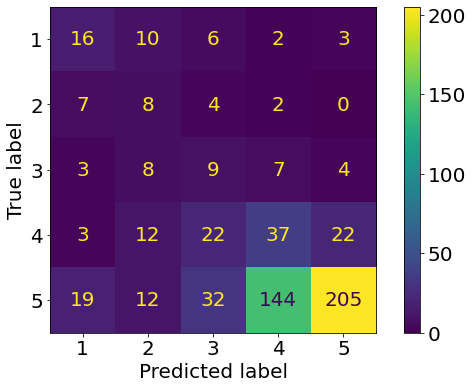

In [ ]:
lg_under, y_pred_untuned_lr_under, y_prob_untuned_lr_under, ba_untuned_lr_under, global_untuned_lr_under = log_scores( X_train_under, X_test, y_train_under, y_test)
bal_acc_scores.append(('LR - Untuned (Under
sampled)', ba_untuned_lr_under))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_lr_under, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_lr_under, 3)))

Accuracy of logistic regression classifier on test set: 0.37
              precision    recall  f1-score   support

           1       0.41      0.38      0.39        37
           2       0.10      0.10      0.10        21
           3       0.28      0.29      0.29        31
           4       0.22      0.29      0.25        96
           5       0.85      0.78      0.81       412

    accuracy                           0.63       597
   macro avg       0.37      0.37      0.37       597
weighted avg       0.66      0.63      0.64       597

Balanced Accuracy: 0.367
Global Accuracy: 0.628


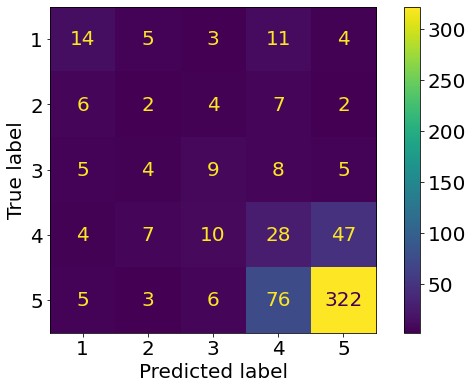

In [ ]:
lg_over, y_pred_untuned_lr_over, y_prob_untuned_lr_over, ba_untuned_lr_over, global_untuned_lr_over = log_scores( X_train_over, X_test, y_train_over, y_test)
bal_acc_scores.append(('LR - Untuned (Oversampled)', ba_untuned_lr_over))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_lr_over, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_lr_over, 3)))

### Model 2: **Untuned** KNN)

In [ ]:
def knn_scores(X_train, X_test, y_train, y_test):
    '''Knn function'''
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    knn.score(X_test, y_test)
    
    
    y_pred_untuned_knn = knn.predict(X_test)
    plot_confusion_matrix(knn, X_test, y_test, values_format = '.0f') 
    y_prob_untuned_knn = knn.predict_proba(X_test)[:, 1]
 
    ba_untuned_knn= balanced_accuracy_score(y_test,y_pred_untuned_knn)
    global_untuned_knn = accuracy_score(y_test, y_pred_untuned_knn)
    print('Accuracy of KNN classifier on test set: {:.2f}'.
                format(ba_untuned_knn))
    print(classification_report(y_test, y_pred_untuned_knn))
    return knn, y_pred_untuned_knn, y_prob_untuned_knn, ba_untuned_knn, global_untuned_knn

Accuracy of KNN classifier on test set: 0.37
              precision    recall  f1-score   support

           1       0.31      0.54      0.39        37
           2       0.12      0.29      0.17        21
           3       0.08      0.19      0.11        31
           4       0.18      0.33      0.24        96
           5       0.86      0.49      0.62       412

    accuracy                           0.44       597
   macro avg       0.31      0.37      0.31       597
weighted avg       0.65      0.44      0.50       597

Balanced Accuracy: 0.368
Global Accuracy: 0.444


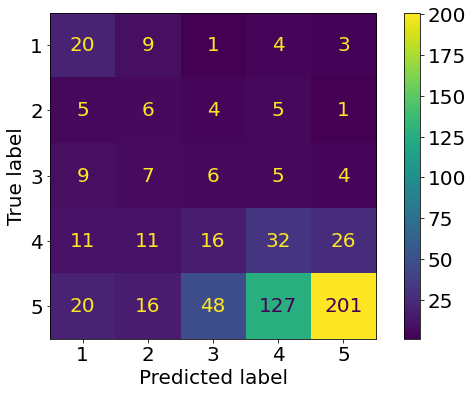

In [ ]:
knn_under, y_pred_untuned_knn_under, y_prob_untuned_knn_under, ba_untuned_knn_under, global_untuned_knn_under = knn_scores(X_train_under, X_test, y_train_under, y_test)
bal_acc_scores.append(('KNN - Untuned (Undersampled)', ba_untuned_knn_under))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_knn_under, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_knn_under, 3)))

Accuracy of KNN classifier on test set: 0.33
              precision    recall  f1-score   support

           1       0.27      0.35      0.31        37
           2       0.12      0.29      0.16        21
           3       0.06      0.16      0.09        31
           4       0.18      0.41      0.25        96
           5       0.90      0.46      0.61       412

    accuracy                           0.42       597
   macro avg       0.31      0.33      0.29       597
weighted avg       0.68      0.42      0.49       597

Balanced Accuracy: 0.333
Global Accuracy: 0.422


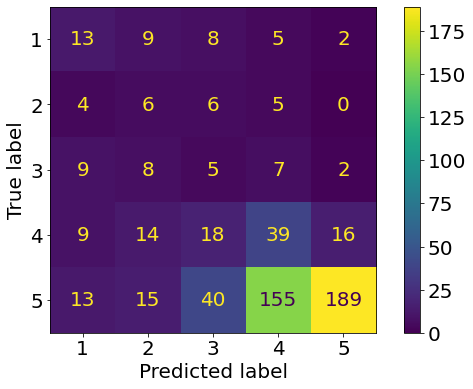

In [ ]:
knn_over, y_pred_untuned_knn_over, y_prob_untuned_knn_over, ba_untuned_knn_over, global_untuned_knn_over = knn_scores(X_train_over, X_test, y_train_over, y_test)
bal_acc_scores.append(('KNN - Untuned (Oversampled)', ba_untuned_knn_over))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_knn_over, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_knn_over, 3)))

### Model 3: **Untuned** SVM

In [ ]:
def svm_scores(X_train, X_test, y_train, y_test):
    '''SVM function'''
    svc= SVC(probability=True)
    svc.fit(X_train, y_train)
    svc.score(X_test, y_test)
    y_pred_untuned_svc = svc.predict(X_test)
    plot_confusion_matrix(svc, X_test, y_test, values_format = '.0f') 
    y_prob_untuned_svc = svc.predict_proba(X_test)[:, 1]
    ba_untuned_svc= balanced_accuracy_score(y_test,y_pred_untuned_svc)
    global_untuned_svc = accuracy_score(y_test, y_pred_untuned_svc)

    print('Accuracy of SVM classifier on test set: {:.2f}'.
                format(ba_untuned_svc))
    print(classification_report(y_test, y_pred_untuned_svc))
   
    return svc, y_pred_untuned_svc, y_prob_untuned_svc, ba_untuned_svc, global_untuned_svc

Accuracy of SVM classifier on test set: 0.41
              precision    recall  f1-score   support

           1       0.50      0.51      0.51        37
           2       0.09      0.19      0.12        21
           3       0.16      0.39      0.23        31
           4       0.21      0.35      0.26        96
           5       0.88      0.59      0.70       412

    accuracy                           0.52       597
   macro avg       0.37      0.41      0.36       597
weighted avg       0.68      0.52      0.58       597

Balanced Accuracy: 0.407
Global Accuracy: 0.521


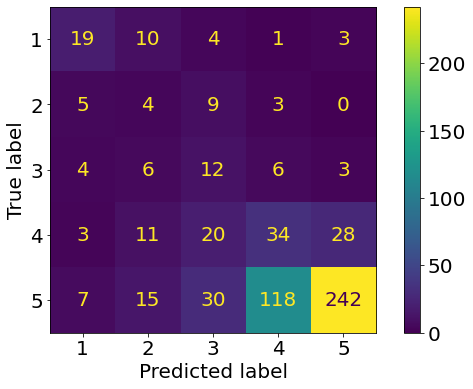

In [ ]:
svc_under, y_pred_untuned_svc_under, y_prob_untuned_svc_under, ba_untuned_svc_under, global_untuned_svc_under = svm_scores(X_train_under, X_test, y_train_under, y_test)
bal_acc_scores.append(('SVC - Untuned (Undersampled)', ba_untuned_svc_under))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_svc_under, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_svc_under, 3)))

Accuracy of SVM classifier on test set: 0.40
              precision    recall  f1-score   support

           1       0.50      0.46      0.48        37
           2       0.12      0.14      0.13        21
           3       0.27      0.23      0.25        31
           4       0.31      0.33      0.32        96
           5       0.85      0.85      0.85       412

    accuracy                           0.68       597
   macro avg       0.41      0.40      0.41       597
weighted avg       0.69      0.68      0.68       597

Balanced Accuracy: 0.402
Global Accuracy: 0.683


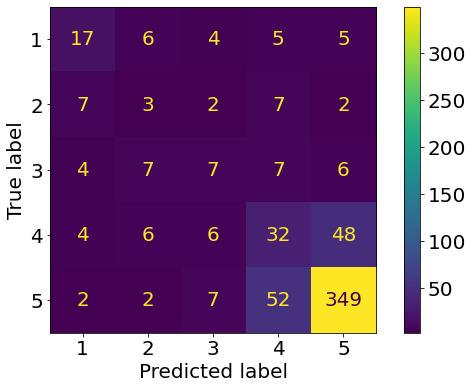

In [ ]:
svc_over, y_pred_untuned_svc_over, y_prob_untuned_svc_over, ba_untuned_svc_over, global_untuned_svc_over = svm_scores(X_train_over, X_test, y_train_over, y_test)
bal_acc_scores.append(('SVC - Untuned (Oversampled)', ba_untuned_svc_over))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_svc_over, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_svc_over, 3)))

### Model 4: **Untuned** RF

In [ ]:
def RandonForest_scores(X_train, X_test, y_train, y_test):
    '''Random Forest'''
    rf=  RandomForestClassifier(max_depth=2, random_state=0)
    rf.fit(X_train, y_train)
    rf.score(X_test, y_test)
    y_pred_untuned_rf = rf.predict(X_test)
    plot_confusion_matrix(rf, X_test, y_test, values_format = '.0f') 
    y_prob_untuned_rf = rf.predict_proba(X_test)[:, 1]
    ba_untuned_rf= balanced_accuracy_score(y_test,y_pred_untuned_rf)
    global_untuned_rf = accuracy_score(y_test, y_pred_untuned_rf)

    print('Accuracy of Random Forrest classifier on test set: {:.2f}'.
                format(ba_untuned_rf))
    print(classification_report(y_test, y_pred_untuned_rf))
   
    return rf, y_pred_untuned_rf, y_prob_untuned_rf, ba_untuned_rf, global_untuned_rf

Accuracy of Random Forrest classifier on test set: 0.41
              precision    recall  f1-score   support

           1       0.49      0.59      0.54        37
           2       0.14      0.24      0.17        21
           3       0.13      0.19      0.16        31
           4       0.26      0.29      0.28        96
           5       0.85      0.75      0.80       412

    accuracy                           0.62       597
   macro avg       0.37      0.41      0.39       597
weighted avg       0.67      0.62      0.64       597

Balanced Accuracy: 0.414
Global Accuracy: 0.621


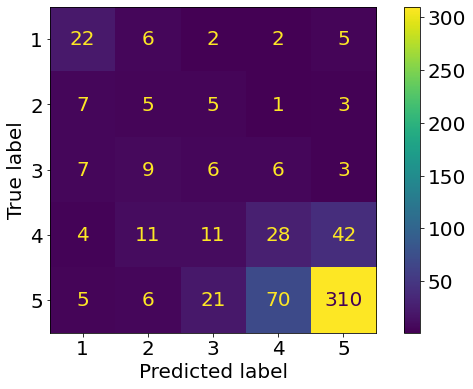

In [ ]:
rf_under, y_pred_untuned_rf_under, y_prob_untuned_rf_under, ba_untuned_rf_under, global_untuned_rf_under = RandonForest_scores(X_train_under, X_test, y_train_under, y_test)
bal_acc_scores.append(('RF - Untuned (Undersampled)', ba_untuned_rf_under))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_rf_under, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_rf_under, 3)))

Accuracy of Random Forrest classifier on test set: 0.42
              precision    recall  f1-score   support

           1       0.46      0.57      0.51        37
           2       0.21      0.29      0.24        21
           3       0.13      0.26      0.18        31
           4       0.27      0.15      0.19        96
           5       0.85      0.84      0.84       412

    accuracy                           0.66       597
   macro avg       0.38      0.42      0.39       597
weighted avg       0.67      0.66      0.66       597

Balanced Accuracy: 0.42
Global Accuracy: 0.663


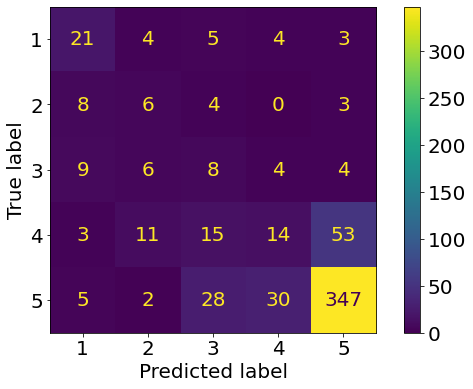

In [ ]:
rf_over, y_pred_untuned_rf_over, y_prob_untuned_rf_over, ba_untuned_rf_over, global_untuned_rf_over = RandonForest_scores(X_train_over, X_test, y_train_over, y_test)
bal_acc_scores.append(('RF - Untuned (Oversampled)', ba_untuned_rf_over))
print('Balanced Accuracy: {}'.format(np.round(ba_untuned_rf_over, 3)))
print('Global Accuracy: {}'.format(np.round(global_untuned_rf_over, 3)))

### Model 5: Tuned LR

In [ ]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('scaler' , StandardScaler()), ('classifier' , LogisticRegression())])

# Create param grid.
param_grid = [{'classifier__penalty' : ['l1', 'l2'],
               'classifier__C' : [100, 10, 1.0, 0.1, 0.01],
               'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear']}
              ]
# Create grid search object
clf = GridSearchCV(pipe, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1, scoring='balanced_accuracy')

Fitting 10 folds for each of 30 candidates, totalling 300 fits


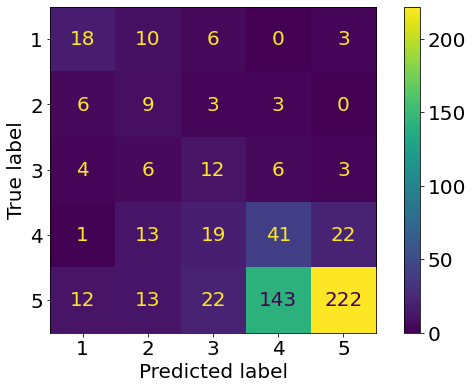

In [ ]:
# Fit on data
best_clf_lr_under = clf.fit(X_train_under, y_train_under)

fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_lr_under.cv_results_[fold_name][best_clf_lr_under.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('LR-Tuned (Undersampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_lr_under, X_test, y_test, values_format = '.0f') 

Fitting 10 folds for each of 30 candidates, totalling 300 fits


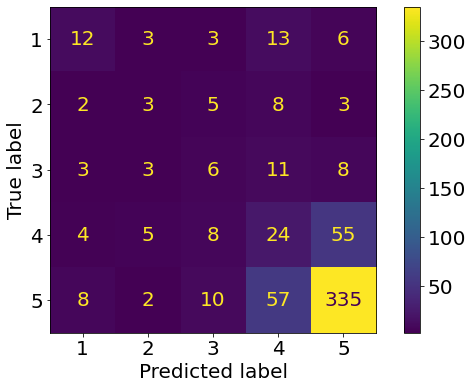

In [ ]:
# Fit on data
best_clf_lr_over = clf.fit(X_train_over, y_train_over)

fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_lr_over.cv_results_[fold_name][best_clf_lr_over.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('LR-Tuned (Oversampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_lr_over, X_test, y_test, values_format = '.0f') 

In [ ]:
"""
y_pred_tuned_lr = best_clf_lr.predict(X_test)
y_prob_tuned_lr = best_clf_lr.predict_proba(X_test)[:, 1]
ba_tuned_lr= balanced_accuracy_score(y_test, y_pred_tuned_lr)
bal_acc_scores.append(('LR - tuned', ba_tuned_lr))
print(classification_report(y_test, y_pred_tuned_lr))
"""

"\ny_pred_tuned_lr = best_clf_lr.predict(X_test)\ny_prob_tuned_lr = best_clf_lr.predict_proba(X_test)[:, 1]\nba_tuned_lr= balanced_accuracy_score(y_test, y_pred_tuned_lr)\nbal_acc_scores.append(('LR - tuned', ba_tuned_lr))\nprint(classification_report(y_test, y_pred_tuned_lr))\n"

### Model 6: Tuned RF

In [ ]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('scaler' , StandardScaler()), ('classifier' , RandomForestClassifier())])

# Create param grid.
param_grid = [{'classifier__n_estimators' : [10, 100, 500],
               'classifier__max_features' : ['sqrt', 'log2'],
               'classifier__max_depth' : [1, 2, 5, None],
               'classifier__max_samples' : [0.33, 0.66, 0.99]}
              ]
# Create grid search object
clf = GridSearchCV(pipe, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


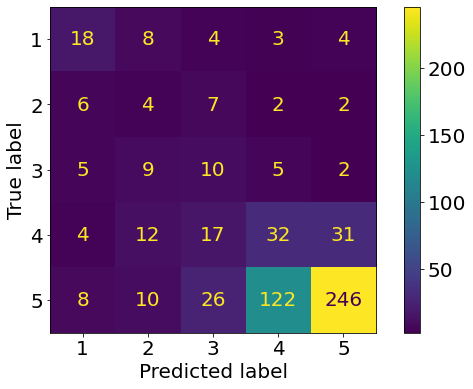

In [ ]:
# Fit on data
best_clf_rf_under = clf.fit(X_train_under, y_train_under)
fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_rf_under.cv_results_[fold_name][best_clf_rf_under.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('RF-Tuned (Undersampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_rf_under, X_test, y_test, values_format = '.0f') 

Fitting 10 folds for each of 72 candidates, totalling 720 fits


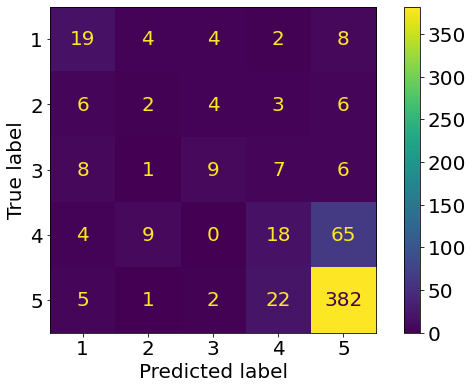

In [ ]:
# Fit on data
best_clf_rf_over = clf.fit(X_train_over, y_train_over)
fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_rf_over.cv_results_[fold_name][best_clf_rf_over.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('RF-Tuned (Oversampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_rf_over, X_test, y_test, values_format = '.0f') 

In [ ]:
382/(382+22+2+1+5) + 18/(65+18+0+9+4) + 9/(9+6+7+9+1+8) + 2/(2+    )

In [ ]:
"""
y_pred_tuned_rf = best_clf_rf.predict(X_test)
y_prob_tuned_rf = best_clf_rf.predict_proba(X_test)[:, 1]
ba_tuned_rf= balanced_accuracy_score(y_test, y_pred_tuned_rf)
bal_acc_scores.append(('RF - tuned', ba_tuned_rf))
print(classification_report(y_test, y_pred_tuned_rf))
"""

"\ny_pred_tuned_rf = best_clf_rf.predict(X_test)\ny_prob_tuned_rf = best_clf_rf.predict_proba(X_test)[:, 1]\nba_tuned_rf= balanced_accuracy_score(y_test, y_pred_tuned_rf)\nbal_acc_scores.append(('RF - tuned', ba_tuned_rf))\nprint(classification_report(y_test, y_pred_tuned_rf))\n"

### Model 7: Tuned SVC

In [ ]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('scaler' , StandardScaler()), ('classifier' , SVC(probability=True))])

# Create param grid.
param_grid = [{'classifier__kernel' : ['linear'],# , 'rbf'
               'classifier__C' : [1, 10],
               'classifier__gamma' : [1e-1, 1e-2]}
              ]

# Create grid search object
clf = GridSearchCV(pipe, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


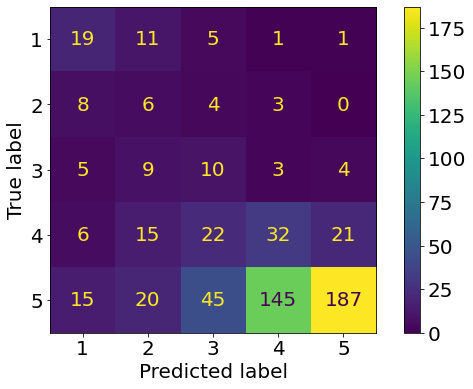

In [ ]:
# Fit on data
best_clf_svm_under = clf.fit(X_train_under, y_train_under)
fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_svm_under.cv_results_[fold_name][best_clf_svm_under.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('SVC-Tuned (Undersampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_svm_under, X_test, y_test, values_format = '.0f') 

Fitting 10 folds for each of 4 candidates, totalling 40 fits


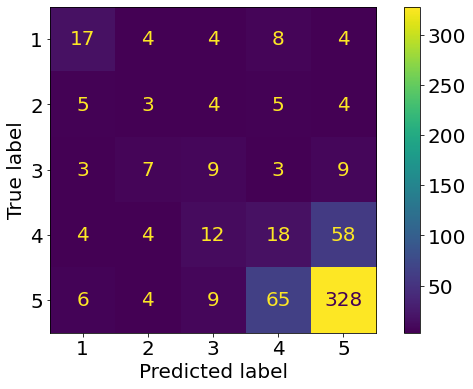

In [ ]:
# Fit on data
best_clf_svm_over = clf.fit(X_train_over, y_train_over)
fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_svm_over.cv_results_[fold_name][best_clf_svm_over.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('SVC-Tuned (Oversampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_svm_over, X_test, y_test, values_format = '.0f') 

In [ ]:
"""
y_pred_tuned_svc = best_clf_svm.predict(X_test)
y_prob_tuned_svc = best_clf_svm.predict_proba(X_test)[:, 1]
ba_tuned_svc= balanced_accuracy_score(y_test, y_pred_tuned_svc)
bal_acc_scores.append(('SVC - tuned', ba_tuned_svc))
print(classification_report(y_test, y_pred_tuned_svc))
"""

"\ny_pred_tuned_svc = best_clf_svm.predict(X_test)\ny_prob_tuned_svc = best_clf_svm.predict_proba(X_test)[:, 1]\nba_tuned_svc= balanced_accuracy_score(y_test, y_pred_tuned_svc)\nbal_acc_scores.append(('SVC - tuned', ba_tuned_svc))\nprint(classification_report(y_test, y_pred_tuned_svc))\n"

### Model 8: Tuned KNN

In [ ]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('scaler' , StandardScaler()), ('classifier' , KNeighborsClassifier())])

# Create param grid.
param_grid = [{'classifier__n_neighbors': [1, 3, 5, 7, 10],
                'classifier__p': [1, 2],
                'classifier__leaf_size': [1, 5, 10, 15]}]


# Create grid search object
clf = GridSearchCV(pipe, param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


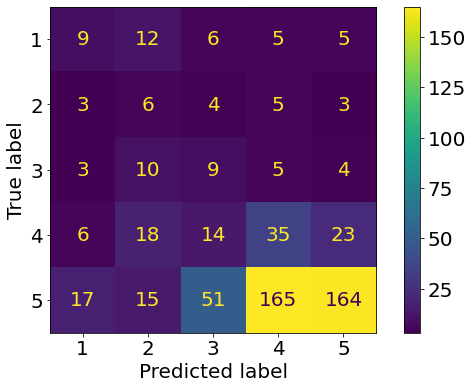

In [ ]:
# Fit on data
best_clf_kn_under = clf.fit(X_train_under, y_train_under)
fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_kn_under.cv_results_[fold_name][best_clf_kn_under.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('KN-Tuned (Undersampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_kn_under, X_test, y_test, values_format = '.0f') 

Fitting 10 folds for each of 40 candidates, totalling 400 fits


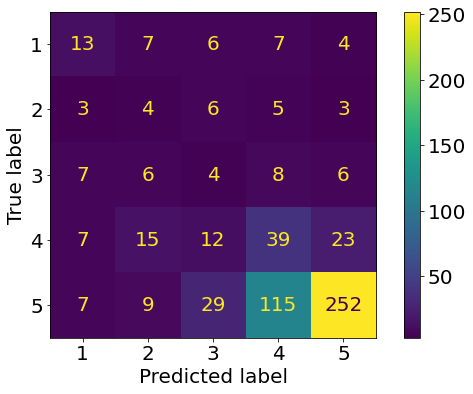

In [ ]:
# Fit on data
best_clf_kn_over = clf.fit(X_train_over, y_train_over)
fold_names = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score',
 'split8_test_score', 'split9_test_score']
fold_scores = []
for fold_name in fold_names:
    fold_score = best_clf_kn_over.cv_results_[fold_name][best_clf_kn_over.best_index_]
    fold_scores.append(fold_score)
fold_scores = ('KN-Tuned (Oversampled)', fold_scores)
boxplot_fold_scores.append(fold_scores)
plot_confusion_matrix(best_clf_kn_over, X_test, y_test, values_format = '.0f') 

In [ ]:
"""
y_pred_tuned_knn = best_clf_kn.predict(X_test)
y_prob_tuned_knn = best_clf_kn.predict_proba(X_test)[:, 1]
ba_tuned_knn = balanced_accuracy_score(y_test, y_pred_tuned_knn)
bal_acc_scores.append(('KNN - tuned', ba_tuned_knn))
print(classification_report(y_test, y_pred_tuned_knn))
"""

"\ny_pred_tuned_knn = best_clf_kn.predict(X_test)\ny_prob_tuned_knn = best_clf_kn.predict_proba(X_test)[:, 1]\nba_tuned_knn = balanced_accuracy_score(y_test, y_pred_tuned_knn)\nbal_acc_scores.append(('KNN - tuned', ba_tuned_knn))\nprint(classification_report(y_test, y_pred_tuned_knn))\n"

In [ ]:
boxplot_fold_scores

[('LR-Tuned (Undersampled)',
  [0.5066666666666667,
   0.42666666666666664,
   0.4066666666666666,
   0.6,
   0.5866666666666667,
   0.30666666666666664,
   0.39333333333333337,
   0.42000000000000004,
   0.5466666666666666,
   0.27999999999999997]),
 ('LR-Tuned (Oversampled)',
  [0.9517885623148782,
   0.9484848484848485,
   0.957587149692413,
   0.959090909090909,
   0.9545454545454545,
   0.959090909090909,
   0.9545454545454545,
   0.9696969696969697,
   0.9469696969696969,
   0.95]),
 ('RF-Tuned (Undersampled)',
  [0.6071428571428571,
   0.35714285714285715,
   0.42857142857142855,
   0.5357142857142857,
   0.5357142857142857,
   0.5357142857142857,
   0.39285714285714285,
   0.4642857142857143,
   0.42857142857142855,
   0.32142857142857145]),
 ('RF-Tuned (Oversampled)',
  [0.9606656580937972,
   0.9561270801815431,
   0.9712556732223904,
   0.9697428139183056,
   0.9652042360060514,
   0.9803030303030303,
   0.9772727272727273,
   0.9757575757575757,
   0.9696969696969697,
   0.

In [ ]:
boxplot_fold_scores = [('LR-Tuned (Undersampled)',
  [0.5066666666666667,
   0.42666666666666664,
   0.4066666666666666,
   0.6,
   0.5866666666666667,
   0.30666666666666664,
   0.39333333333333337,
   0.42000000000000004,
   0.5466666666666666,
   0.27999999999999997]),
 ('LR-Tuned (Oversampled)',
  [0.9517885623148782,
   0.9484848484848485,
   0.957587149692413,
   0.959090909090909,
   0.9545454545454545,
   0.959090909090909,
   0.9545454545454545,
   0.9696969696969697,
   0.9469696969696969,
   0.95]),
 ('RF-Tuned (Undersampled)',
  [0.6071428571428571,
   0.35714285714285715,
   0.42857142857142855,
   0.5357142857142857,
   0.5357142857142857,
   0.5357142857142857,
   0.39285714285714285,
   0.4642857142857143,
   0.42857142857142855,
   0.32142857142857145]),
 ('RF-Tuned (Oversampled)',
  [0.9606656580937972,
   0.9561270801815431,
   0.9712556732223904,
   0.9697428139183056,
   0.9652042360060514,
   0.9803030303030303,
   0.9772727272727273,
   0.9757575757575757,
   0.9696969696969697,
   0.9757575757575757]),
 ('SVC-Tuned (Undersampled)',
  [0.42857142857142855,
   0.35714285714285715,
   0.42857142857142855,
   0.4642857142857143,
   0.5714285714285714,
   0.2857142857142857,
   0.35714285714285715,
   0.32142857142857145,
   0.5,
   0.25]),
 ('SVC-Tuned (Oversampled)',
  [0.9425113464447806,
   0.9485627836611196,
   0.9591527987897126,
   0.9652042360060514,
   0.9515885022692889,
   0.956060606060606,
   0.953030303030303,
   0.9545454545454546,
   0.95,
   0.953030303030303]),
 ('KN-Tuned (Undersampled)',
  [0.39285714285714285,
   0.39285714285714285,
   0.4642857142857143,
   0.5,
   0.4642857142857143,
   0.2857142857142857,
   0.39285714285714285,
   0.39285714285714285,
   0.25,
   0.32142857142857145]),
 ('KN-Tuned (Oversampled)',
  [0.9107413010590015,
   0.9077155824508321,
   0.9198184568835098,
   0.9016641452344932,
   0.9016641452344932,
   0.9257575757575758,
   0.9348484848484848,
   0.9196969696969697,
   0.9212121212121213,
   0.9227272727272727])]

In [ ]:
bal_acc_scores

[('LR - Untuned (Oversampled)', 0.3973393752461244),
 ('LR - Untuned (Oversampled)', 0.3674318237973108),
 ('KNN - Untuned (Undersampled)', 0.3682001248709673),
 ('KNN - Untuned (Oversampled)', 0.33266876474479046),
 ('SVC - Untuned (Undersampled)', 0.40652635712532365),
 ('SVC - Untuned (Oversampled)', 0.40170875318072313),
 ('RF - Untuned (Undersampled)', 0.41406641418385864),
 ('RF - Untuned (Oversampled)', 0.4198825424905913)]

In [ ]:
bal_acc_scores = [('LR - Untuned (Undersampled)', 0.3973393752461244),
 ('LR - Untuned (Oversampled)', 0.3674318237973108),
 ('KNN - Untuned (Undersampled)', 0.3682001248709673),
 ('KNN - Untuned (Oversampled)', 0.33266876474479046),
 ('SVC - Untuned (Undersampled)', 0.40652635712532365),
 ('SVC - Untuned (Oversampled)', 0.40170875318072313),
 ('RF - Untuned (Undersampled)', 0.41406641418385864),
 ('RF - Untuned (Oversampled)', 0.4198825424905913)]

Text(0.5, 0, 'Classifiers')

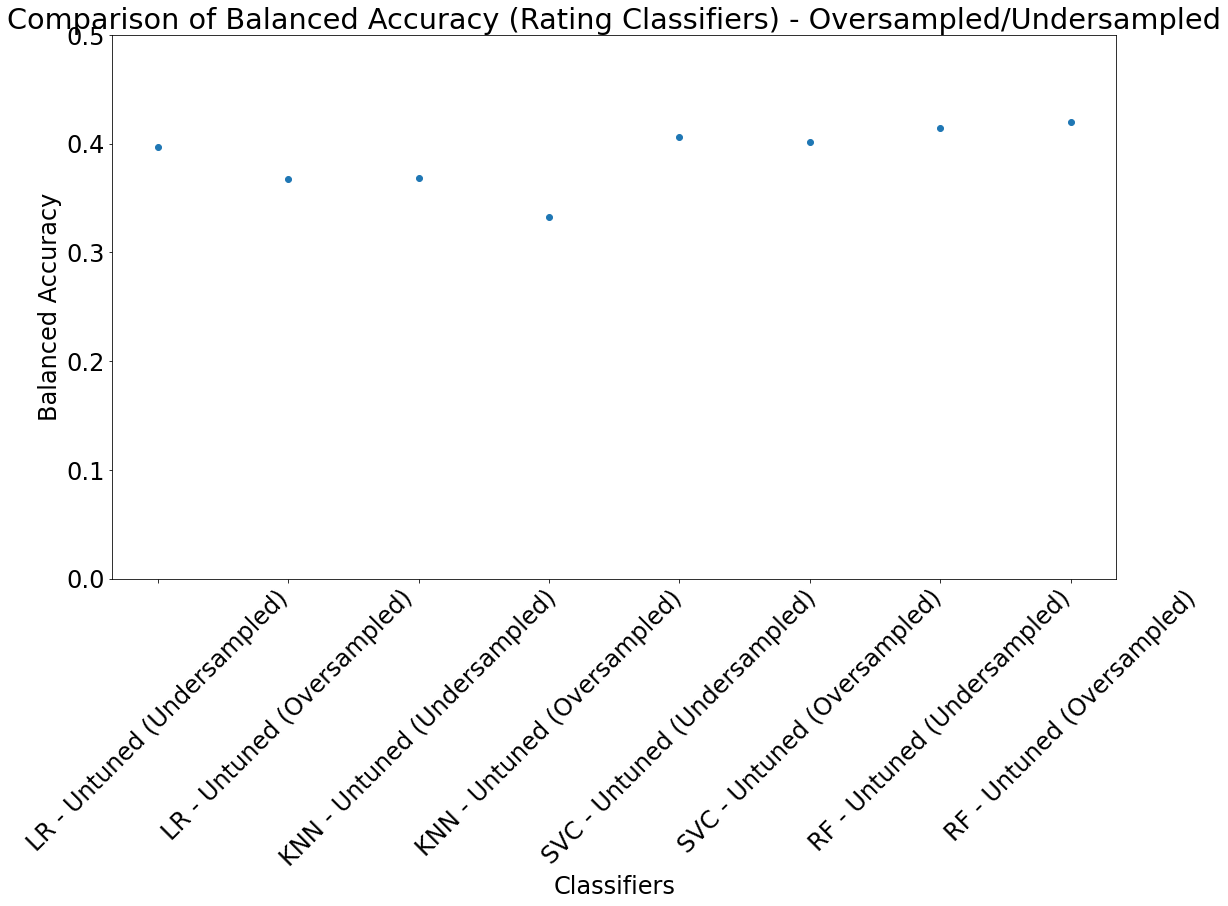

In [ ]:
x_val = [x[0] for x in bal_acc_scores]
y_val = [x[1] for x in bal_acc_scores]
plt.scatter(x_val, y_val)
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.title('Comparison of Balanced Accuracy (Rating Classifiers) - Oversampled/Undersampled')
plt.ylabel('Balanced Accuracy')
plt.xlabel('Classifiers')


### Comparison of Cross-validation Accuracy for a Range of Algorithms

In [ ]:
names = [x[0] for x in boxplot_fold_scores]
results = [x[1] for x in boxplot_fold_scores]

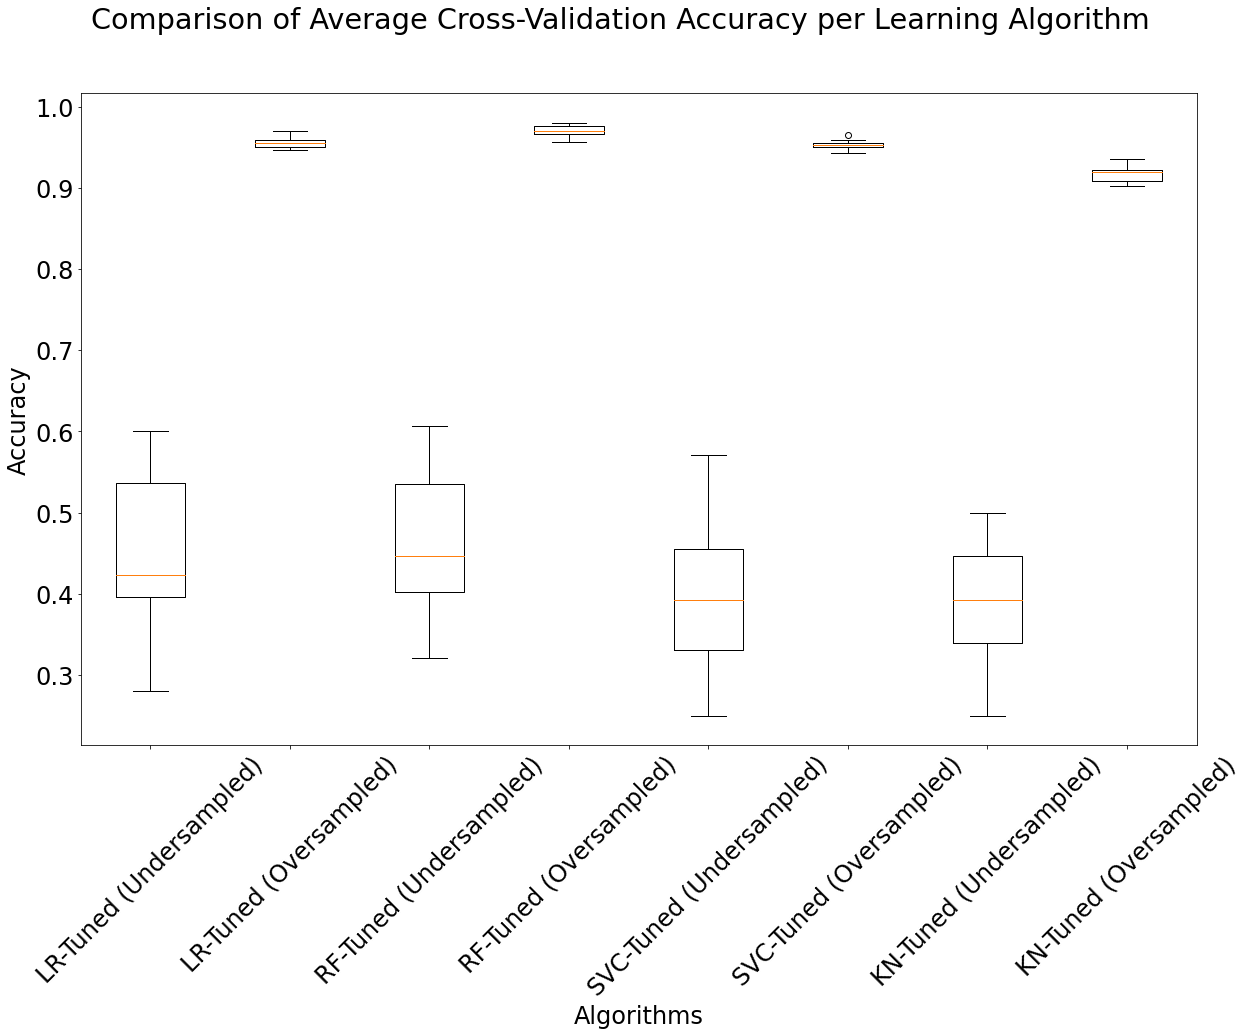

In [ ]:
plt.rcParams["figure.figsize"] = (20,12)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparison of Average Cross-Validation Accuracy per Learning Algorithm')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Algorithms')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#y_pred_untuned_lr = y_pred_untuned_lr.astype(int)
#y_pred_tuned_lr = y_pred_tuned_lr.astype(int)
#y_pred_tuned_rf = y_pred_tuned_rf.astype(int)
#y_test = y_test.astype(int)

In [ ]:
plt.rcParams["figure.figsize"] = (24,15)

plt.figure(0).clf()

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

fpr, tpr, thresh = metrics.roc_curve(y_test, ns_probs)
auc = metrics.roc_auc_score(y_test, ns_probs)
plt.plot(fpr, tpr, linestyle='--', label="No skill, AUC="+str(np.round(auc, 3)))

# Untuned Algorithms
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_untuned_lr)
auc1 = metrics.roc_auc_score(y_test, y_pred_untuned_lr)
plt.plot(fpr,tpr,label="LR - untuned, AUC="+str(np.round(auc1, 3)))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_untuned_rf)
auc2 = metrics.roc_auc_score(y_test, y_pred_untuned_rf)
plt.plot(fpr, tpr, label="RF - untuned, AUC="+str(np.round(auc2, 3)))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_untuned_svc)
auc3 = metrics.roc_auc_score(y_test, y_pred_untuned_svc)
plt.plot(fpr, tpr, label="SVC - untuned, AUC="+str(np.round(auc3, 3)))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_untuned_knn)
auc4 = metrics.roc_auc_score(y_test, y_pred_untuned_knn)
plt.plot(fpr, tpr, label="KNN - untuned, AUC="+str(np.round(auc4, 3)))

"""
# Tuned Algorithms
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_tuned_lr)
auc5 = metrics.roc_auc_score(y_test, y_pred_tuned_lr)
plt.plot(fpr,tpr,label="LR - tuned, AUC="+str(np.round(auc5, 3)))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_tuned_svc)
auc6 = metrics.roc_auc_score(y_test, y_pred_tuned_svc)
plt.plot(fpr,tpr,label="SVC - tuned, AUC="+str(np.round(auc6, 3)))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_tuned_rf)
auc7 = metrics.roc_auc_score(y_test, y_pred_tuned_rf)
plt.plot(fpr,tpr,label="RF - tuned, AUC="+str(np.round(auc7, 3)))

fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob_tuned_knn)
auc8 = metrics.roc_auc_score(y_test, y_pred_tuned_knn)
plt.plot(fpr,tpr,label="KNN - tuned, AUC="+str(np.round(auc8, 3)))
"""

plt.legend(loc=0)
plt.title('Comparison of ROC curves for a range of learning algorithms')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.rcParams["figure.figsize"] = (15,10)

ValueError: ignored

<Figure size 1728x1080 with 0 Axes>

In [ ]:
df_results

In [ ]:
aucs = [auc1, auc4, auc3, auc2, auc5, auc7, auc6, auc8]
aucs

In [ ]:
bal_acc_scores_values

In [ ]:
bal_acc_scores_values = [x[1] for x in bal_acc_scores]
bal_acc_scores_names = [x[0] for x in bal_acc_scores]

In [ ]:
plt.rcParams["figure.figsize"] = (20,12)
#df_results = pd.DataFrame({'Balanced Accuracy': bal_acc_scores_values, 'AUC': aucs}, index=bal_acc_scores_names)
df_results = pd.DataFrame({'Balanced Accuracy': bal_acc_scores_values}, index=bal_acc_scores_names)
df_results.plot.bar(rot=45, legend=None)
plt.title('Balanced Accuracy on Test Set Data for Tuned and Untuned Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')

In [ ]:
#best_models = pd.concat([rs_ftestfdr_1pc, rs_ftestfdr_5pc, rs_boostaroota, rs_pca, rs_baseline,
#                         rs_20000_rf[rs_20000_rf['Top N Ranked Features'] == 3250],
#                         rs_20000_linearSVR[rs_20000_linearSVR['Top N Ranked Features'] == 8500],
#                         rs_20000_mig[rs_20000_mig['Top N Ranked Features'] == 6500],
#                         rs_20000_pearsonr[rs_20000_pearsonr['Top N Ranked Features'] == 750]])
#best_models.rename(columns={'Top N Ranked Features': 'Stage 1 Feature Selection', 'Non-zero Coefs after EN': 'Stage 2 Feature Selection'}, inplace=True)

#best_models = best_models.groupby('Feat Sel')[['Stage 1 Feature Selection', 'Stage 2 Feature Selection', 'Test Corr Per Run']].mean().reset_index()
best_models.iloc[:, 0:3].plot(kind='bar')
best_models['Feat Sel'] = best_models['Feat Sel'].map(name_map)

plt.title('Best Feature Selection Models  - Feature Set Size and Nested CV Correlation (Pred. vs. Actual)', fontsize=40)
plt.xlabel('Feature Selection Methods', fontsize=34)
plt.ylabel('No. of Features', fontsize=34)

plt.xticks(fontsize=28, rotation=45)
plt.yticks(fontsize=28)
plt.legend(fontsize=28, loc='upper right')
plt.yscale('log')

plt.twinx()
plt.yticks(fontsize=28)
plt.scatter(best_models['Feat Sel'], best_models['Test Corr Per Run'], color='red', marker='x', s=120,  linewidth=5)
plt.ylim(0, 0.35)

In [ ]:
lr_scores = [0.8724928366762177,
   0.8681948424068768,
   0.8467048710601719,
   0.8853868194842407,
   0.8536788196159799,
   0.8780505878865725,
   0.8565688502453644,
   0.8636621875308763,
   0.8593930112307744,
   0.8636951223528637]

In [ ]:
np.std(lr_scores)

In [ ]:
rf_scores = [0.8896848137535817,
   0.8853868194842407,
   0.8610315186246418,
   0.8839541547277937,
   0.8852223816355811,
   0.9024390243902439,
   0.8823529411764706,
   0.8708751793400287,
   0.8723098995695839,
   0.866571018651363]

In [ ]:
np.std(rf_scores)

In [ ]:
svc_scores = [0.8825214899713467,
   0.8767908309455588,
   0.8553008595988538,
   0.8825214899713467,
   0.8737446197991392,
   0.8866571018651362,
   0.866571018651363,
   0.8694404591104734,
   0.8737446197991392,
   0.8737446197991392]

In [ ]:
np.std(svc_scores)

In [ ]:
knn_scores = [0.7707736389684814,
   0.7550143266475645,
   0.7406876790830945,
   0.7535816618911175,
   0.7690100430416069,
   0.7589670014347202,
   0.7790530846484935,
   0.7517934002869441,
   0.7661406025824964,
   0.7489239598278336]

In [ ]:
np.std(knn_scores)